<a id='top'></a>
# Analys av COVID-19 i Sverige

All data kommer från [Folkhälsomyndigheten](https://www.folkhalsomyndigheten.se/smittskydd-beredskap/utbrott/aktuella-utbrott/covid-19/bekraftade-fall-i-sverige/).

Folkhälsomyndigheten visar sin statistik [här](https://experience.arcgis.com/experience/09f821667ce64bf7be6f9f87457ed9aa).

### Innehållsförteckning
1. [Antal fall över tid](#antal_fall_över_tid)
1. [Fördelning av sjukdomsfall](#sjukdomsutfall)
1. [Avlidna vs antal fall](#scatter)
1. [Effective reproduction rate](#R)
1. [Pandemiutveckling](#trajectory)
1. [SEIRD model](#seir)
1. [Underrapportering - UK](#underrapportering_uk)
1. [Underrapportering - Sverige](#underrapportering_se)

In [1]:
import datetime
import os
import re
import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import xlrd
%matplotlib inline

df = pd.read_excel("Sweden_statistics/Folkhalsomyndigheten_Covid19.xlsx")
dfi = df.set_index('Statistikdatum')

df_region = pd.read_excel("Sweden_statistics/Folkhalsomyndigheten_Covid19.xlsx", sheet_name=3, index_col='Region')
df_region['Population'] = df_region['Totalt_antal_fall']/df_region['Fall_per_100000_inv']
df_region['Intensivvårdade_per_100000_inv'] = df_region['Totalt_antal_intensivvårdade']/df_region['Population']
df_region['Avlidna_per_100000_inv'] = df_region['Totalt_antal_avlidna']/df_region['Population']

<a id='antal_fall_över_tid'></a>
## Antal fall över tid

[Tillbaka till början](#top)

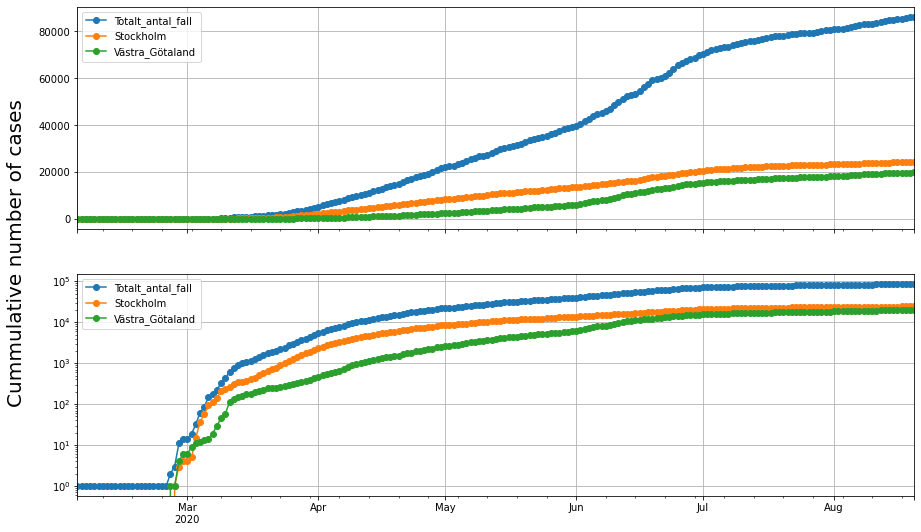

In [2]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))

y = [
    'Totalt_antal_fall',
    'Stockholm',
    'Västra_Götaland',
#     'Sörmland',
]
dfi.cumsum().plot(y=y, style='-o', grid=True, logy=False, ax=ax1)
dfi.cumsum().plot(y=y, style='-o', grid=True, logy=True, ax=ax2)

ax2.set_xlabel('')
fig.text(0.06, 0.5, 'Cummulative number of cases', va='center', rotation='vertical', fontsize=20);

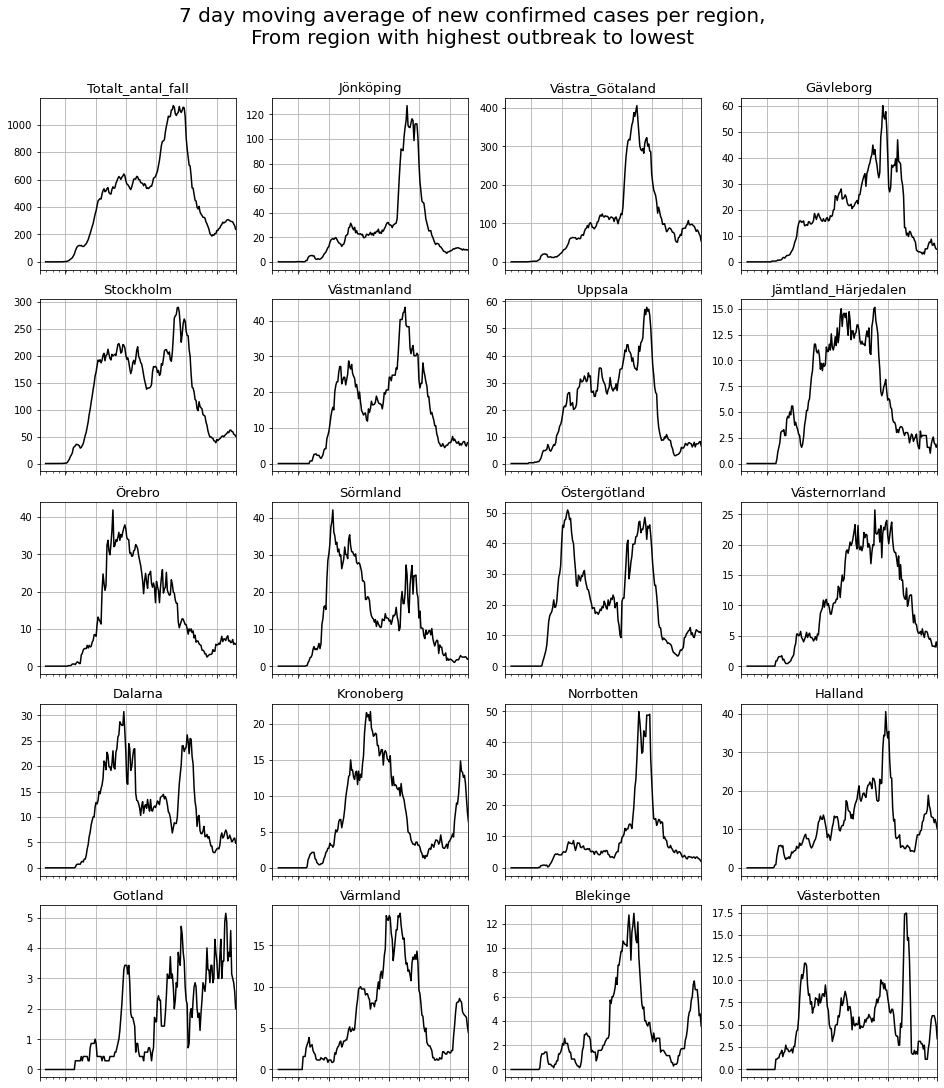

In [3]:
regions = [
    "Totalt_antal_fall",
    "Blekinge",
    "Dalarna",
    "Gotland",
    "Gävleborg",
    "Halland",
    "Jämtland_Härjedalen",
    "Jönköping",
    "Kalmar",
    "Kronoberg",
    "Norrbotten",
    "Skåne",
    "Stockholm",
    "Sörmland",
    "Uppsala",
    "Värmland",
    "Västerbotten",
    "Västernorrland",
    "Västmanland",
    "Västra_Götaland",
    "Örebro",
    "Östergötland"]


sorted_regions = list(df_region.Fall_per_100000_inv.sort_values(ascending=False).index)
sorted_regions = [i.replace(' ', '_') for i in sorted_regions]
sorted_regions.insert(0, 'Totalt_antal_fall')
for region in sorted_regions:
    if region not in regions:
        sorted_regions.remove(region)

    
nrows = 5
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13,15), constrained_layout=True, sharex=True)
axes = np.reshape(axes, -1)

window = 7
fig.suptitle(f'{window} day moving average of new confirmed cases per region,\nFrom region with highest outbreak to lowest\n', fontsize=20)
for region, ax in zip(sorted_regions, axes):
    df_temp = dfi[region].rolling(window).mean()
    df_temp.plot(grid=True, ax=ax, color='k')
    ax.set_title(region, fontsize=13)
    
    ax.set_xlabel('')
    ax.set_xticklabels('')


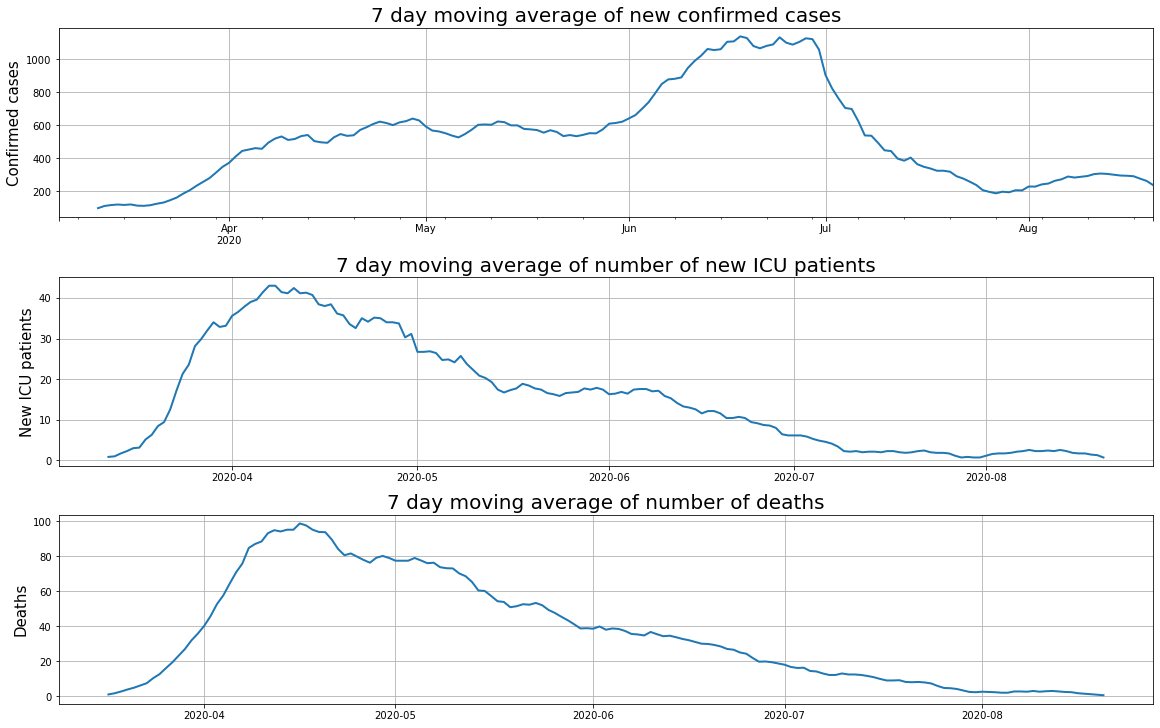

In [4]:
p = "Sweden_statistics/old_FHM_statistics"
files = os.listdir(p)

# Find the latest statistic
date_pattern = re.compile("_(\d{8})")
latest_file = None
latest_date = datetime.date(2000,1,1)
datetime.datetime.strptime('20200510', '%Y%m%d').date()
for file in files:
    date = date_pattern.search(file)
    if date:
        date = datetime.datetime.strptime(date.group(1), '%Y%m%d').date()
        if date > latest_date:
            latest_file = file
            latest_date = date
        
last_stat_file = p + '/' + latest_file

df_icu = pd.read_excel(last_stat_file, sheet_name=2, index_col=0)
df_icu.index = [d.date() for d in df_icu.index]

df_corona_deaths = pd.read_excel(last_stat_file, sheet_name=1, skipfooter=1, index_col=0)
df_corona_deaths.index = [d.date() for d in df_corona_deaths.index]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, constrained_layout=True, figsize=(16,10))
roll_val = 7

dfi.iloc[31:,:].rolling(roll_val).mean().plot(y='Totalt_antal_fall', grid=True, legend=False, ax=ax1, lw=2)
ax1.set_title(f'{roll_val} day moving average of new confirmed cases', fontsize=20)
ax1.set_ylabel('Confirmed cases', fontsize=15)
ax1.set_xlabel('');

df_icu.rolling(roll_val).mean().plot(grid=True, legend=False, ax=ax2, lw=2)
ax2.set_title(f'{roll_val} day moving average of number of new ICU patients', fontsize=20)
ax2.set_ylabel('New ICU patients', fontsize=15)
ax2.set_xlabel('');

df_corona_deaths.rolling(roll_val).mean().plot(grid=True, legend=False, ax=ax3, lw=2)
ax3.set_title(f'{roll_val} day moving average of number of deaths', fontsize=20)
ax3.set_ylabel('Deaths', fontsize=15)
ax3.set_xlabel('');

<a id='sjukdomsutfall'></a>
## Fördelning av sjukdomsutfall

[Tillbaka till början](#top)

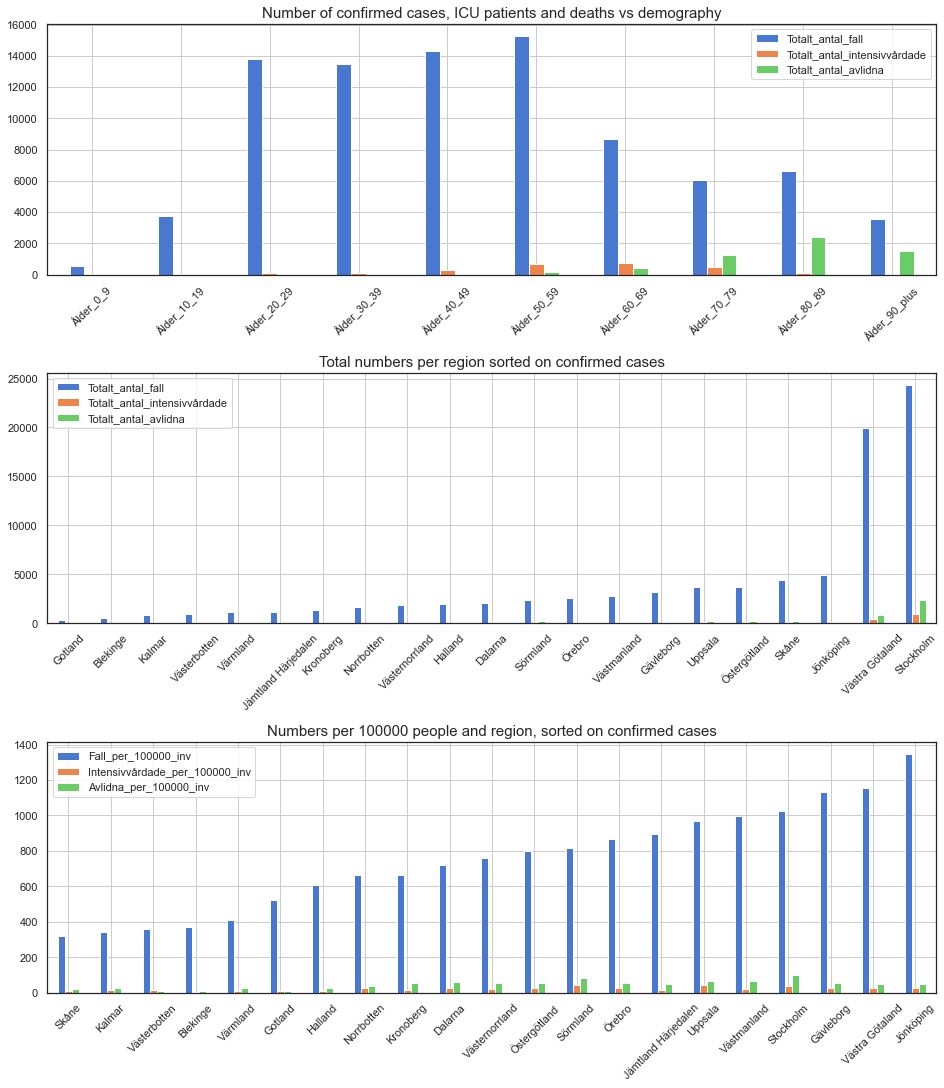

In [5]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

df_age = pd.read_excel("Sweden_statistics/Folkhalsomyndigheten_Covid19.xlsx", sheet_name=5)
df_age = df_age.iloc[:-1]
df_age.set_index('Åldersgrupp', inplace=True)



fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, constrained_layout=True, figsize=(13,15))

df_age.plot(kind='bar', grid=True, ax=ax1, rot=45)
ax1.set_title('Number of confirmed cases, ICU patients and deaths vs demography', fontsize=15)
ax1.set_xlabel('')

df_region.sort_values(by=['Totalt_antal_fall']).plot.bar(y=['Totalt_antal_fall', 'Totalt_antal_intensivvårdade', 'Totalt_antal_avlidna'], grid=True, ax=ax2, rot=45)
ax2.set_xlabel('')
ax2.set_title('Total numbers per region sorted on confirmed cases', fontsize=15)

df_region.sort_values(by=['Fall_per_100000_inv']).plot.bar(y=['Fall_per_100000_inv', 'Intensivvårdade_per_100000_inv', 'Avlidna_per_100000_inv'], grid=True, ax=ax3, rot=45)
ax3.set_xlabel('')
ax3.set_title('Numbers per 100000 people and region, sorted on confirmed cases', fontsize=15);

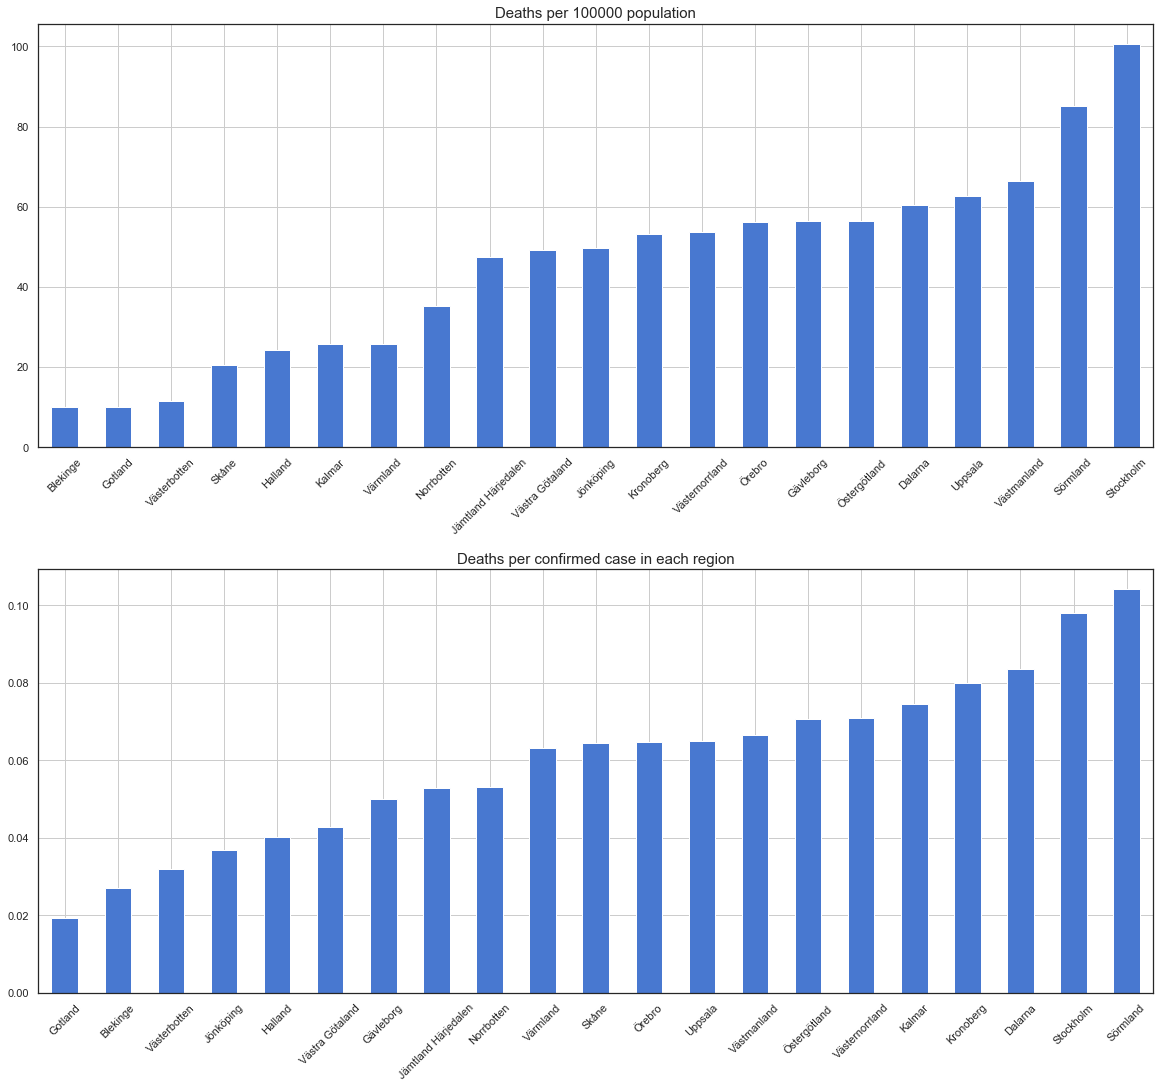

In [6]:
df_avlidna = pd.DataFrame(df_region['Totalt_antal_avlidna']*df_region['Fall_per_100000_inv']/df_region['Totalt_antal_fall'])
df_avlidna.columns = ['Avlidna_per_100000_inv']
df_avlidna['Avlidna_per_fall'] = df_region['Totalt_antal_avlidna'] / df_region['Totalt_antal_fall']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(16,15), constrained_layout=True)

df_avlidna['Avlidna_per_100000_inv'].sort_values().plot(kind='bar', grid=True, rot=45, ax=ax1)
ax1.set_title('Deaths per 100000 population', fontsize=15)
ax1.set_xlabel('')

df_avlidna['Avlidna_per_fall'].sort_values().plot(kind='bar', grid=True, rot=45, ax=ax2)
ax2.set_title('Deaths per confirmed case in each region', fontsize=15)
ax2.set_xlabel('');

<a id='scatter'></a>
## Avlidna vs antal fall

[Tillbaka till början](#top)

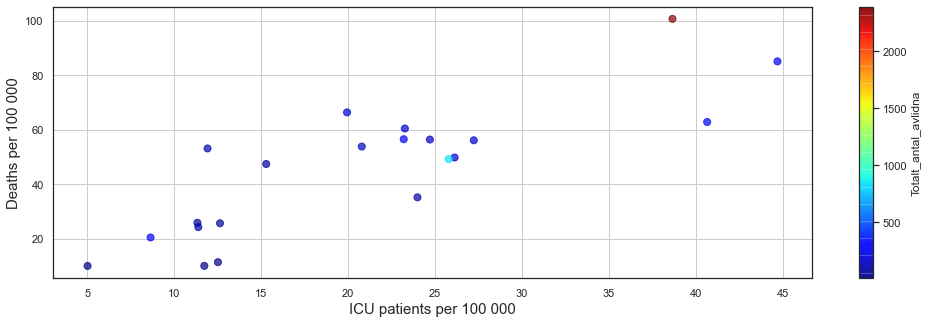

In [7]:
fig, ax = plt.subplots(figsize=(17,5))
plot_kwargs = {
    'grid': True,
    's': 50,
    'alpha': 0.7,
    'c': 'Totalt_antal_avlidna',
    'colormap': 'jet', 
    'ax': ax,}

df_region.plot.scatter(x='Intensivvårdade_per_100000_inv', y='Avlidna_per_100000_inv', **plot_kwargs)
ax.set_ylabel('Deaths per 100 000', fontsize=15)
ax.set_xlabel('ICU patients per 100 000', fontsize=15);


<a id='R'></a>
## Effective reproduction rate

[Tillbaka till början](#top)

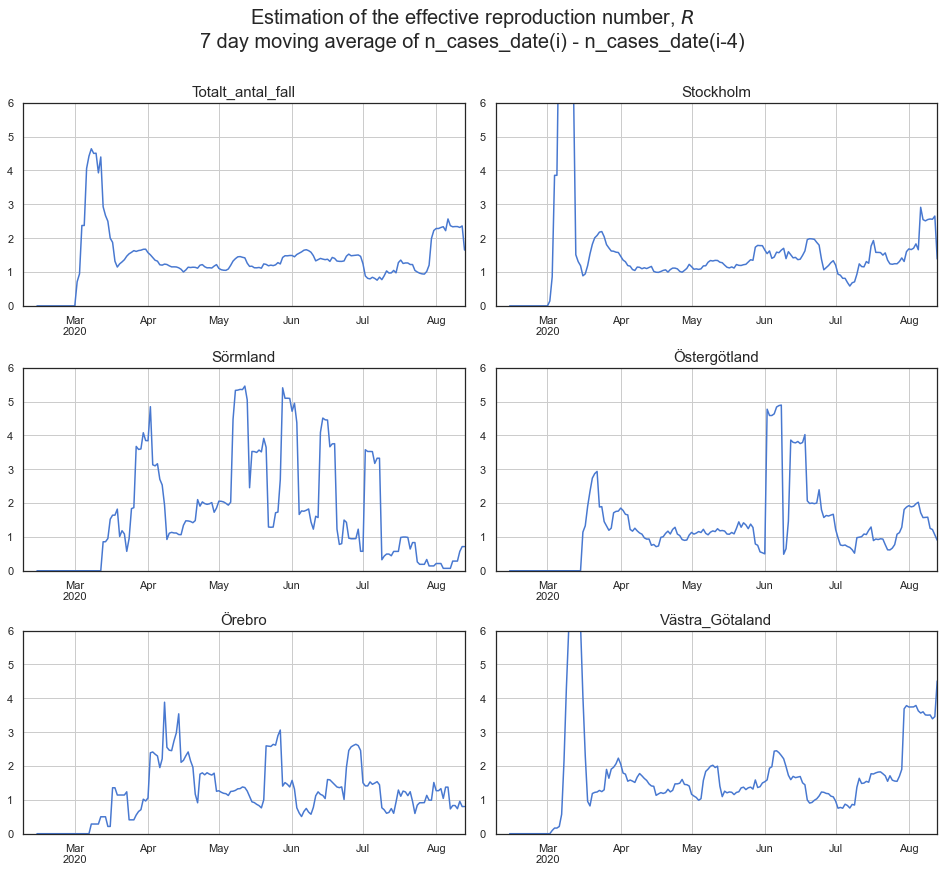

In [8]:
shift = 4
mavg = 7
df_R_index = dfi.index.to_numpy()[shift:-7]
df_R = pd.DataFrame(dfi.to_numpy()[shift:-7] / dfi.replace(0, np.inf).to_numpy()[:-shift-7], columns=dfi.columns, index=df_R_index)
df_R = df_R.rolling(mavg).mean()

regions = ['Totalt_antal_fall', 'Stockholm', 'Sörmland', 'Östergötland', 'Örebro', 'Västra_Götaland']
n_rows = np.ceil(len(regions)/2).astype(int)

n_cols = 1 if len(regions)==1 else 2
fig, axes = plt.subplots(n_rows, n_cols, constrained_layout=True, figsize=(13,12))
axes = np.reshape(axes, -1)
fig.suptitle(f'Estimation of the effective reproduction number, $R$\n{mavg} day moving average of n_cases_date(i) - n_cases_date(i-{shift})\n', fontsize=20);
for region, ax in zip(regions, axes):
    df_R.plot(y=[region], grid=True, ax=ax, legend=False)
    ax.set_title(region, fontsize=15)
    ax.set_ylim([0, 6]);

<a id='trajectory'></a>
## Pandemiutveckling

Denna beräkningen är tagen från youtubekanalen [minutephysics](https://www.youtube.com/watch?v=54XLXg4fYsc)

[Tillbaka till början](#top)

C:\Users\Fredrik\miniconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Fredrik\miniconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


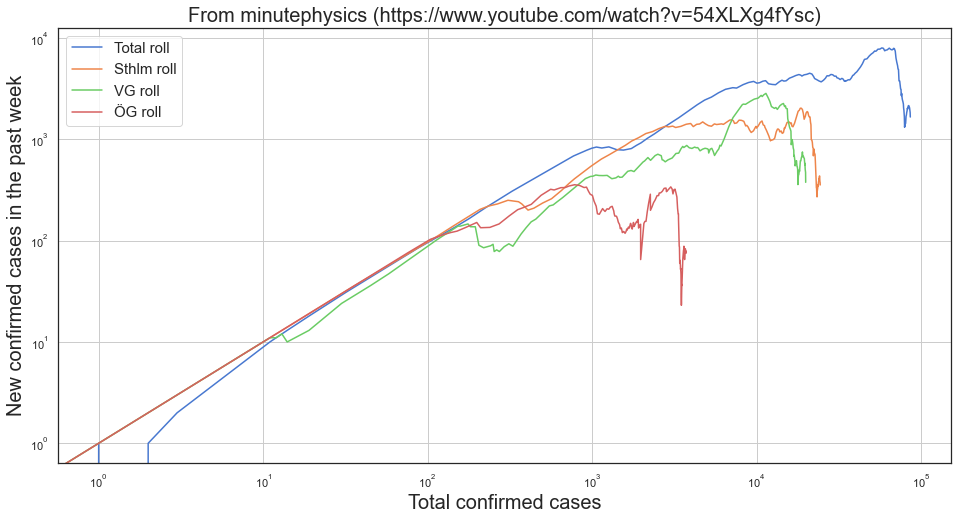

In [9]:
minutephysics = "https://www.youtube.com/watch?v=54XLXg4fYsc"
cols = ['Totalt_antal_fall', 'Stockholm', 'Västra_Götaland', 'Östergötland']
df_mp = df[cols]
df_mp.loc[:,'sthlm_roll'] = df_mp['Stockholm'].rolling(7).sum()
df_tmp = df_mp[cols].rolling(7).sum()
df_tmp.columns = ['Total roll', 'Sthlm roll', 'VG roll', 'ÖG roll']
df_roll = pd.concat([df_mp.cumsum(), df_tmp], axis=1, sort=False)

fig, ax = plt.subplots(figsize=(16,8))
df_roll.plot(x='Totalt_antal_fall', y='Total roll', grid=True, loglog=True, ax=ax)
df_roll.plot(x='Stockholm', y='Sthlm roll', grid=True, loglog=True, ax=ax)
df_roll.plot(x='Västra_Götaland', y='VG roll', grid=True, loglog=True, ax=ax)
df_roll.plot(x='Östergötland', y='ÖG roll', grid=True, loglog=True, ax=ax)

ax.set_ylabel('New confirmed cases in the past week', fontsize=20)
ax.set_xlabel('Total confirmed cases', fontsize=20)
ax.set_title(f"From minutephysics ({minutephysics})", fontsize=20)
ax.legend(fontsize=15);


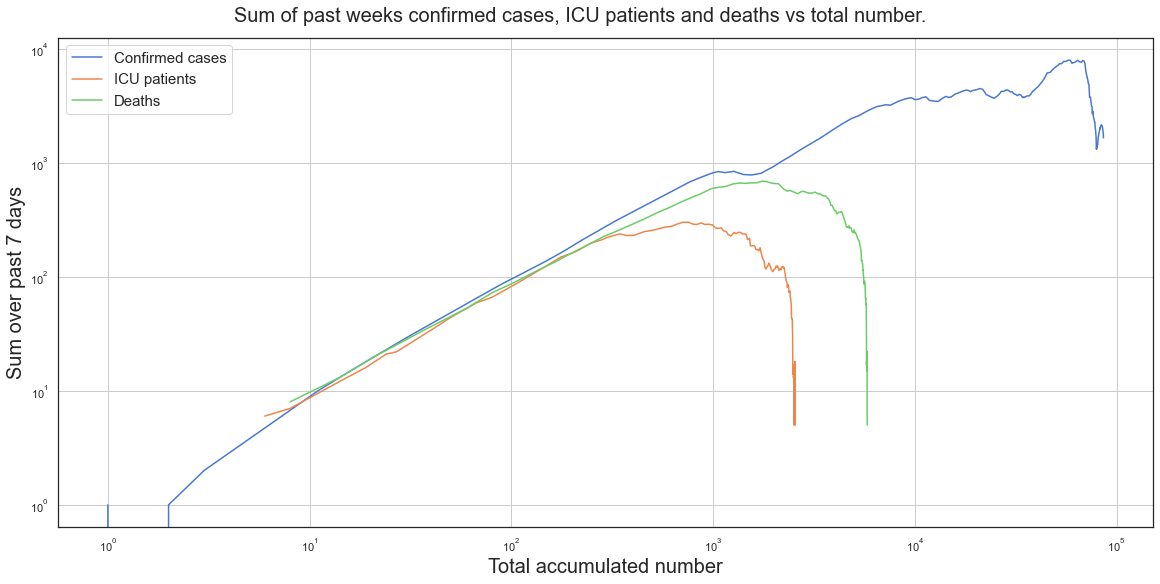

In [10]:
def mp_vectors(df):
    x = df.cumsum()
    y = df.rolling(7).sum()
    return x, y

fig, ax = plt.subplots(1, 1, figsize=(16,8), constrained_layout=True)
fig.suptitle('Sum of past weeks confirmed cases, ICU patients and deaths vs total number.', fontsize=20)

# Confirmed cases
x, y = mp_vectors(df['Totalt_antal_fall'])
ax.loglog(x, y, label='Confirmed cases')
ax.legend(fontsize=15, loc='upper left')

# ICU patients
x, y = mp_vectors(df_icu)
ax.loglog(x, y, label='ICU patients')
ax.legend(fontsize=15, loc='upper left')

# Deaths
x, y = mp_vectors(df_corona_deaths)
ax.loglog(x, y, label='Deaths')
ax.legend(fontsize=15, loc='upper left')

ax.set_ylabel('Sum over past 7 days', fontsize=20)
ax.set_xlabel('Total accumulated number', fontsize=20)
ax.grid()

<a id='seir'></a>
## SIR model

SEIR-modell beskrivs [här](https://www.idmod.org/docs/hiv/model-seir.html)

[Tillbaka till början](#top)

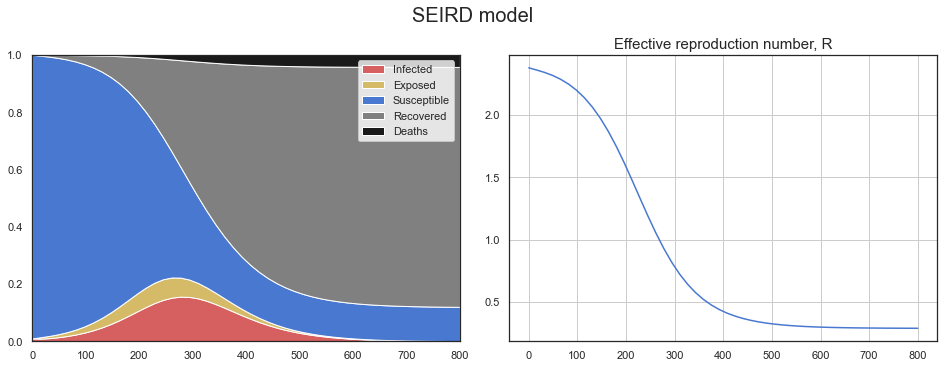

In [11]:

def seir(y, t, N, beta, sigma, gamma, theta=0, rho=0):
    """
    beta:  Infection rate (leaving S)
    sigma: Infectious rate (leaving E)
    gamma: Recovery rate 
    theta: Death rate
    rho:   Loss of immunity rate
    """
    S, E, I, R, D = y[0], y[1], y[2], y[3], y[4]
    
    dS = rho*R - beta*I*S/N
    dE = beta*I*S/N - sigma*E
    dI = sigma*E - (gamma + theta)*I
    dR = gamma*I - rho*R
    dD = theta*I
    
    return [dS, dE, dI, dR, dD]

N = 1
S0 = 0.99*N
E0 = 0
I0 = (N-S0)
R0 = 0
D0 = 0

r0 = 2.5
beta  = 0.05
sigma = 0.05
gamma = beta*S0/N/r0
theta = 0.001
rho = 0

y0 = [S0, E0, I0, R0, D0]
t_max = 800
t = np.linspace(0, t_max)

soln = odeint(seir, y0, t, args=(N, beta, sigma, gamma, theta, rho))
S, E, I, R, D = soln[:,0], soln[:,1], soln[:,2], soln[:,3], soln[:,4]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,5), constrained_layout=True)
fig.suptitle('SEIRD model', fontsize=20)

ax1.stackplot(t, [I,E,S,R,D], labels=['Infected','Exposed','Susceptible','Recovered','Deaths'], colors=['r', 'y', 'b', 'gray', 'k'])
ax1.legend()
ax1.axis([0, t_max, 0, N])


r = (beta*S*I/N + rho*R) / ((gamma + theta)*I)
ax2.plot(t,r)
ax2.grid()
ax2.set_title('Effective reproduction number, R', fontsize=15);

<a id='underrapportering_uk'></a>
## Underrapportering - UK

Källa: [Office of national statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales)


[Tillbaka till början](#top)

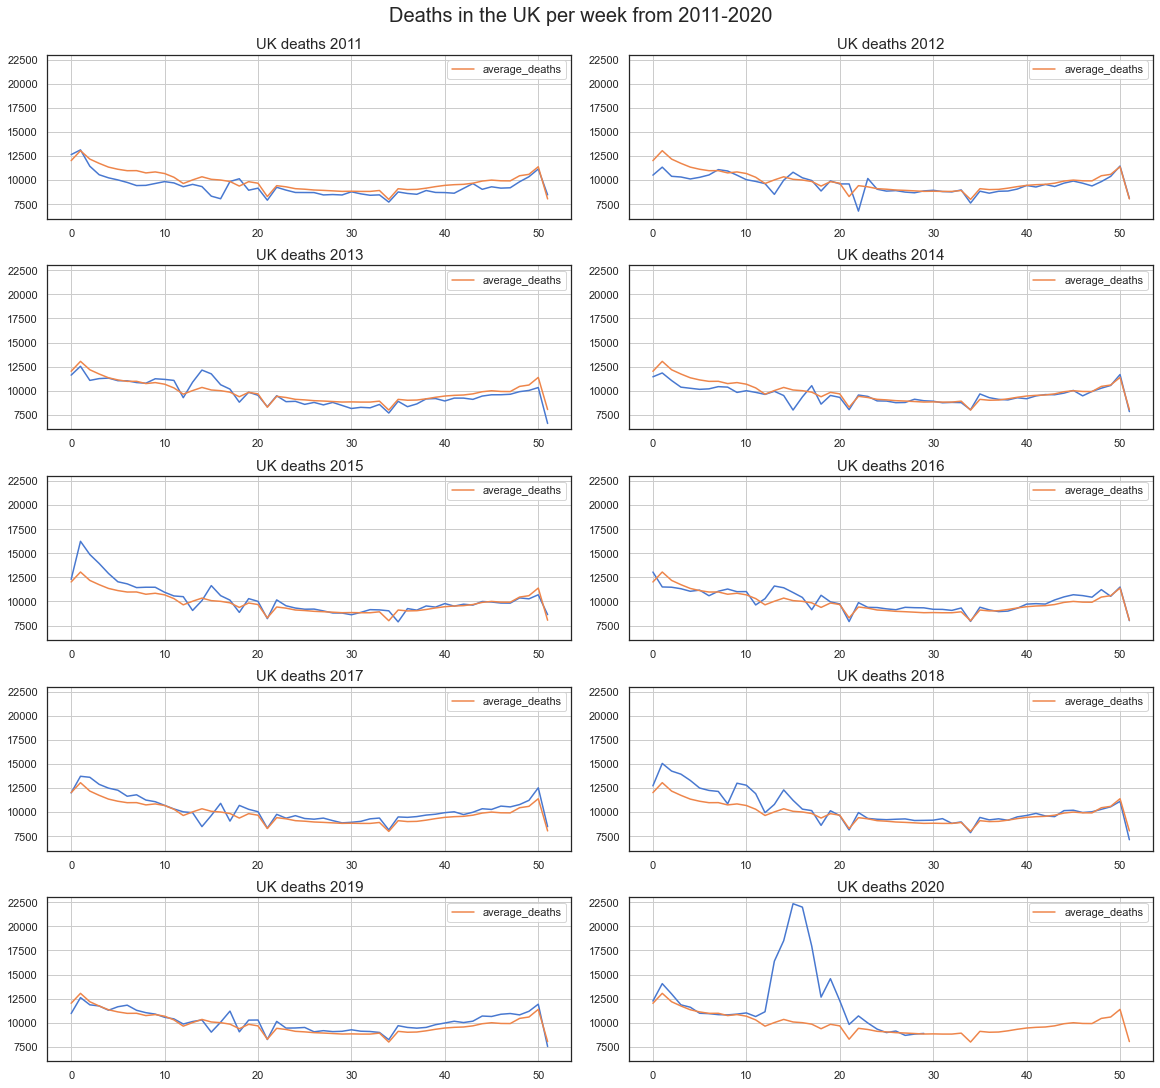

In [12]:
# Read historical deaths excel file
uk_historical_excel = f"UK_statistics/historical_weekly_deaths_uk.xlsx"
workbook = xlrd.open_workbook(uk_historical_excel, on_demand=True)
worksheet = workbook.sheet_by_index(0)

# Store weekly deaths from 2010-2019 in dataframe
weeks = [i for i in range(1,53)]
uk_hist_deaths = {f'{2010+i}_deaths': worksheet.row_values(i+1,1,53) for i in range(10)}

# Find most recent 2020 death statistics excel file
uk_2020_death_ptrn = re.compile(r'publishedweek(\d{1,2})2020.xlsx')
uk_2020_stat_excel = "publishedweek242020.xlsx"
for file in os.listdir("UK_statistics/"):
    if uk_2020_death_ptrn.findall(file):
        tmp_week = uk_2020_death_ptrn.search(file).group(1)
        if tmp_week > uk_2020_death_ptrn.search(uk_2020_stat_excel).group(1):
            uk_2020_stat_excel = file

# Get all 2020 deaths
workbook = xlrd.open_workbook('UK_statistics/' + uk_2020_stat_excel, on_demand=True)
worksheet = workbook.sheet_by_index(4)
uk_2020_deaths = worksheet.row_values(8,2,53)
uk_latest_week = uk_2020_deaths.index('')
uk_2020_deaths = uk_2020_deaths[:uk_latest_week]

worksheet = workbook.sheet_by_index(5)
uk_covid_deaths = worksheet.row_values(8,2,uk_latest_week+2)

# Collect all information above in a dataframe
df_uk_deaths = pd.DataFrame(uk_hist_deaths)
df_uk_deaths['average_deaths'] = df_uk_deaths.mean(axis=1)
df_uk_deaths['2020_deaths'] = np.nan
df_uk_deaths['2020_deaths'].iloc[:uk_latest_week] = uk_2020_deaths
df_uk_deaths['covid_deaths'] = np.nan
df_uk_deaths['covid_deaths'].iloc[:uk_latest_week] = uk_covid_deaths

# Find first week with covid death
idx_first_death = df_uk_deaths.covid_deaths.ne(0).idxmax()

# Calculate excess deaths w.r.t. 2020
for year in range(2010,2020):
    df_uk_deaths[f'excess_deaths_{year}'] = df_uk_deaths['2020_deaths'] - df_uk_deaths[f'{year}_deaths']

fig, ax = plt.subplots(5, 2, figsize=(16,15), constrained_layout=True)
ax = np.reshape(ax,-1)
fig.suptitle('Deaths in the UK per week from 2011-2020', fontsize=20)

for i, year in enumerate(range(2011, 2021)):
    df_uk_deaths.rolling(1).mean().plot(y=[f'{year}_deaths'], grid=True, legend=False, ax=ax[i])
    df_uk_deaths.rolling(1).mean().plot(y=['average_deaths'], grid=True, legend=True, ax=ax[i])
    ax[i].set_title(f'UK deaths {year}', fontsize=15)
    ax[i].set_ylim([6000, 23000])


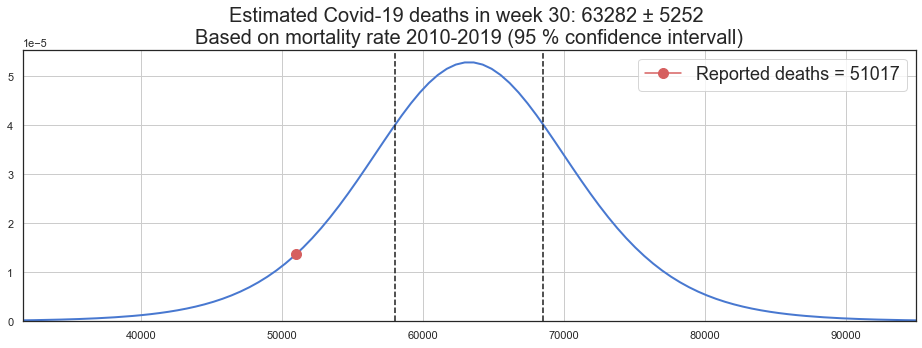

In [13]:
# Mean deaths for all years
years = np.arange(2010,2020)
X = df_uk_deaths[[f'excess_deaths_{year}' for year in years]].iloc[idx_first_death:uk_latest_week,:].sum()
X_mean = X.mean()

# Sample variance for all years
n = len(years)
X_var = sum((X_mean-X)**2)/(n-1)
S = np.sqrt(X_var)

# two sided t-value from the t-distribution
deg = n-1
t_value = stats.t.ppf(0.975, df=deg)

# Confidence intervall
ci = t_value*S/np.sqrt(n)

fig, ax = plt.subplots(figsize=(16,5))
x = np.linspace(0, 2*X_mean, 200)
ax.plot(x, stats.t.pdf(x, deg, loc=X_mean, scale=S), lw=2)
ax.grid()
ax.set_title(f"Estimated Covid-19 deaths in week {uk_latest_week}: {round(X_mean):0.0f} \u00B1 {round(ci):0.0f} \nBased on mortality rate 2010-2019 (95 % confidence intervall)", fontsize=20);
ax.set_xlim([X_mean/2, 1.5*X_mean])
ylim = ax.get_ylim()
ax.set_ylim([0, ylim[1]])

ax.plot([X_mean-ci]*2, [0, ylim[1]], '--k')
ax.plot([X_mean+ci]*2, [0, ylim[1]], '--k');

reported_deaths = df_uk_deaths['covid_deaths'].sum()
dist_y = stats.t.pdf(reported_deaths, deg, loc=X_mean, scale=S)
ax.plot(reported_deaths, dist_y, marker='o', color='r', markersize=10, label=f'Reported deaths = {int(reported_deaths)}')
ax.legend(fontsize=18);

<a id='underrapportering_se'></a>
## Underrapportering - Sverige

Statistik över totalt antal döda hämtas från [SCB](https://scb.se/hitta-statistik/statistik-efter-amne/befolkning/befolkningens-sammansattning/befolkningsstatistik/) (Preliminär statistik över döda).

Se även [New York Times](https://www.nytimes.com/interactive/2020/04/21/world/coronavirus-missing-deaths.html) artikel.

[Tillbaka till början](#top)

### Antal dödsfall 2020 jämfört med tidigare år

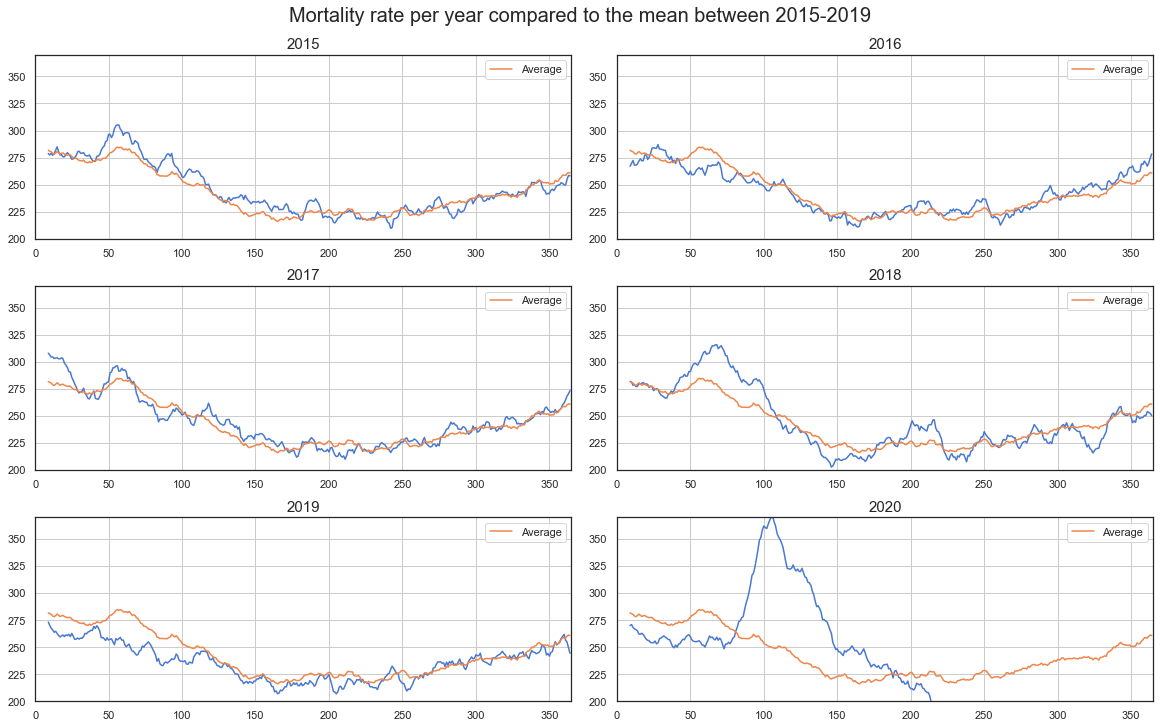

In [14]:
date_pattern = re.compile(r"\d{4}-\d{2}-\d{2}")

scb_file = '2020-04-17---preliminar-statistik-over-doda-inkl-eng.xlsx'
scb_date = datetime.datetime.fromisoformat(scb_file.split('---')[0])
for file in os.listdir('Sweden_statistics/SCB_statistik'):
    if 'preliminar' in file:
        date_temp = date_pattern.findall(file)[0]
        file_date = datetime.datetime.fromisoformat(date_temp)
        if file_date > scb_date:
            scb_file = file
            scb_date = datetime.datetime.fromisoformat(date_temp)

workbook = xlrd.open_workbook(f"Sweden_statistics/SCB_statistik/{scb_file}", on_demand=True)
worksheet = workbook.sheet_by_name('Tabell 1')
df_corona_deaths = pd.read_excel("Sweden_statistics/Folkhalsomyndigheten_Covid19.xlsx", sheet_name=1, usecols="B")

dates = worksheet.col_values(0,7,373)

deaths_2015 = worksheet.col_values(1, 7, 373)
deaths_2016 = worksheet.col_values(2, 7, 373)
deaths_2017 = worksheet.col_values(3, 7, 373)
deaths_2018 = worksheet.col_values(4, 7, 373)
deaths_2019 = worksheet.col_values(5, 7, 373)
deaths_2020 = worksheet.col_values(6, 7, 373)
deaths_avg = worksheet.col_values(7, 7, 373)

data = {
    'Deaths_2015': deaths_2015,
    'Deaths_2016': deaths_2016,
    'Deaths_2017': deaths_2017,
    'Deaths_2018': deaths_2018,
    'Deaths_2019': deaths_2019,
    'Deaths_2020': deaths_2020,
    'Deaths_average': deaths_avg,
}

df_sweden = pd.DataFrame(data, index=dates)
df_sweden.drop(['29 februari'], inplace=True)
df_sweden.loc[df_sweden['Deaths_2020'] == 0, 'Deaths_2020'] = np.nan

deaths_mavg_per_year = []
for i in data.keys():
    if not 'average' in i:
        deaths_mavg_per_year.append(df_sweden[i].rolling(10).mean().to_list())

fig, ax = plt.subplots(3,2,figsize=(16,10), constrained_layout=True)
fig.suptitle('Mortality rate per year compared to the mean between 2015-2019', fontsize=20)
ax = np.reshape(ax,-1)

year = 2015
ylims = [1000, 0]
for axes, y in zip(ax, deaths_mavg_per_year):
    axes.plot(y, label='')
    axes.plot(df_sweden['Deaths_average'].rolling(10).mean().to_list(), label='Average')
    axes.grid(True)
    axes.set_title(f"{year}", fontsize=15)
    axes.legend()
    y_min, y_max = axes.get_ylim()
    axes.axis([0, 365, 200, 370])
    year+=1


### Deaths 2015 - 2020

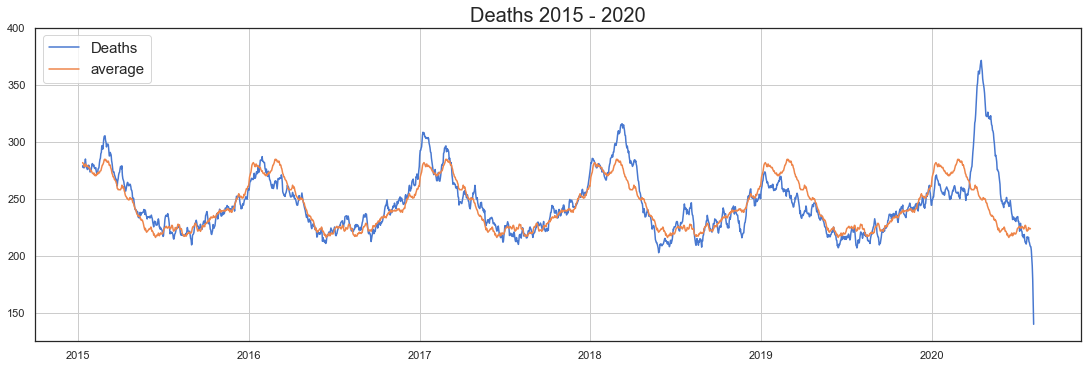

In [15]:
x, y, avg = [], [], []

for i in df_sweden.columns[:-1]:
    if i[:8] == 'Deaths_2':
        x.extend(df_sweden.index.to_list())
        y.extend(df_sweden[i].to_list())
        avg.extend(df_sweden['Deaths_average'].to_list())

# Create dataframe
df_all_years = pd.DataFrame({'Date': x, 'Deaths': y, 'average': avg})
df_all_years.set_index('Date', inplace=True)

# Remove last 7 days of 2020 deaths
last_index_2020 = df_sweden.Deaths_2020.isnull().sum()
df_all_years.iloc[-last_index_2020-7:,1] = np.nan

# Plot
fig, ax = plt.subplots(1,1, figsize=(15,5), constrained_layout=True)
df_all_years.rolling(10).mean().plot(y=['Deaths', 'average'], 
                                     grid=True, 
                                     xticks=[0, 365, 730, 1095, 1460, 1825], 
                                     legend=True, 
                                     ax=ax)
ax.set_xlabel('')
ax.set_title('Deaths 2015 - 2020', fontsize=20)
ax.set_ylim([125, 400]);
ax.legend(fontsize=15, loc=2);
ax.set_xticklabels(['2015', '2016', '2017', '2018', '2019', '2020']);



### Antal dödsfall 2020 jämfört med tidigare år, exklusive covid-dödsfall

[Tillbaka till början](#top)

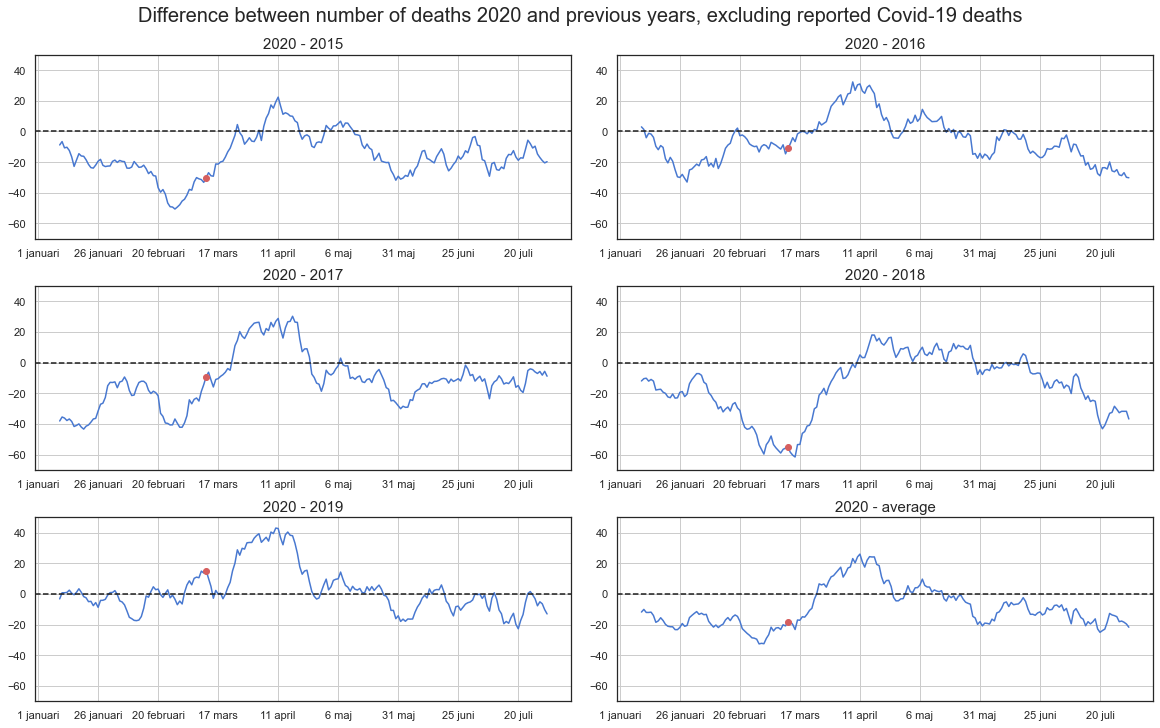

In [16]:

list_corona_deaths = df_corona_deaths['Antal_avlidna'].to_list()
df_sweden['Corona_deaths'] = 0
index_first_death = 70
index_last_day = index_first_death+len(list_corona_deaths)
df_sweden.iloc[index_first_death:index_last_day,7] = list_corona_deaths

for year in data.keys():
    year = year.split('_')[-1]
    df_sweden[f'Excess_deaths_{year}'] = df_sweden['Deaths_2020'] - df_sweden[f'Deaths_{year}']
    df_sweden[f'Difference_{year}'] = df_sweden[f'Excess_deaths_{year}'] - df_sweden['Corona_deaths']

fig, ax = plt.subplots(3, 2, figsize=(16,10), constrained_layout=True)
fig.suptitle('Difference between number of deaths 2020 and previous years, excluding reported Covid-19 deaths', fontsize=20)
ax = np.reshape(ax,-1)
last_reliable_day = min(index_last_day, deaths_2020.index(0))-7


year = ['2015', '2016', '2017', '2018', '2019', 'average']
for y, axes in zip(year, ax):
    df_sweden.rolling(10).mean().iloc[:last_reliable_day,:].plot(y=[f'Difference_{y}'], grid=True, legend=False, ax=axes)
    axes.plot(index_first_death, df_sweden.rolling(10).mean().iloc[index_first_death,:][f'Difference_{y}'], 'ro')
    axes.set_title(f'2020 - {y}', fontsize=15)
    axes.axhline(color='k', ls='--')
    axes.set_ylim([-70, 50])

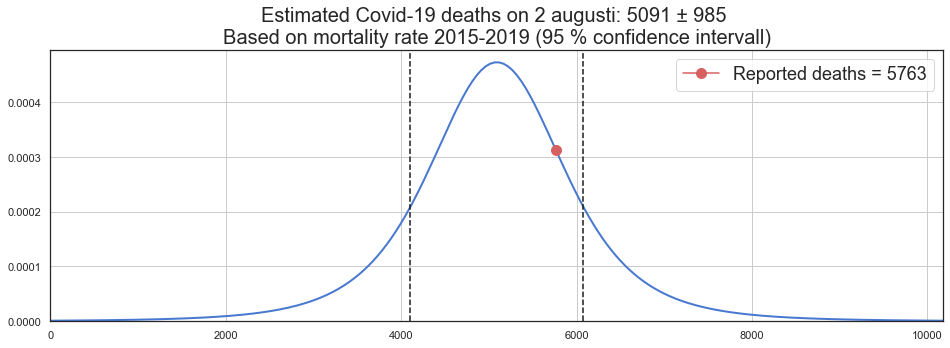

In [17]:
## Mean deaths for all years
years = np.arange(2015,2020)
X = df_sweden[[f'Excess_deaths_{year}' for year in years]].iloc[index_first_death:last_reliable_day,:].sum()
X_mean = X.mean()

# Sample variance for all years
n = len(years)
X_var = sum((X_mean-X)**2)/(n-1)
S = np.sqrt(X_var)

# two sided t-value from the t-distribution
deg = n-1
t_value = stats.t.ppf(0.975, df=deg)

# Confidence intervall
ci = t_value*S/np.sqrt(n)

# print(f"Number of Covid-19 deaths is estimated to be {X_mean} \u00B1 {round(ci):0.0f} based on mortality rate 2015-2019 (95 % confidence intervall)")

fig, ax = plt.subplots(figsize=(16,5))
x = np.linspace(0, 2*X_mean, 200)
ax.plot(x, stats.t.pdf(x, deg, loc=X_mean, scale=S), lw=2)
ax.grid()
stat_day = df_sweden.index[last_reliable_day]
ax.set_title(f"Estimated Covid-19 deaths on {stat_day}: {round(X_mean):0.0f} \u00B1 {round(ci):0.0f} \nBased on mortality rate 2015-2019 (95 % confidence intervall)", fontsize=20);
ax.set_xlim([0, 2*X_mean])
ylim = ax.get_ylim()
ax.set_ylim([0, ylim[1]])

ax.plot([X_mean-ci]*2, [0, ylim[1]], '--k')
ax.plot([X_mean+ci]*2, [0, ylim[1]], '--k');

reported_deaths = df_sweden['Corona_deaths'].iloc[index_first_death:last_reliable_day].sum()
dist_y = stats.t.pdf(reported_deaths, deg, loc=X_mean, scale=S)
ax.plot(reported_deaths, dist_y, marker='o', color='r', markersize=10, label=f'Reported deaths = {reported_deaths}')
ax.legend(fontsize=18);

In [18]:
# df_who = pd.read_csv('WHO-COVID-19-global-data.csv')
# df_who.groupby(['day', 'Country Name']).sum()

## Rapportering Belgien

[Officiell statistik över alla dödsfall](https://statbel.fgov.be/en/covid-19-statbel-data)

[Covid-19](https://epistat.wiv-isp.be/covid/)

[Tillbaka till början](#top)

## Rapportering Nederländerna
[Covid-19](https://www.cbs.nl/en-gb/figures/detail/70895ENG)

[Tillbaka till början](#top)

## EU

[Världsdata från ECDC](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide)

[Tillbaka till början](#top)

## WHO
[Världsdata från WHO](https://covid19.who.int/)

Under kartan finns en länk för att ladda ned källfilen.

[Tillbaka till början](#top)